In [1]:
import ipyparallel as ipp
rc = ipp.Client()
view = rc[:]

In [2]:
%%px --local
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  7 16:06:27 2018

@author: Usuario
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

def delayed_signal(signal, m, tau):
    signal_length=signal.shape[0]
    delayed=np.zeros((m,signal_length-(m-1)*tau))
    for idx in range(m):
        start = (m-1-idx) * tau
        end = signal_length - idx * tau
        delayed[idx, :]= signal[start:end]
    return delayed

def euclidean(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

def distance_matrix(signal,w,h):
    rows, columns = signal.shape
    distance = np.ones((columns, columns)) * np.inf
    for j in range(columns-h):
        for i in range(j+1+w, columns-h):
            distance[i,j] = euclidean(signal[:, i], signal[:, j])
            distance[j,i]=distance[i,j]
    return distance

def prediction_error(signal, dist, m, tau, h, k):
    # dist_sorted_ind returns in each i row the k nearest neihbors 
    # corresponding to point i
    dist_sorted_ind=np.argsort(dist)
    signal_length=signal.shape[0]
    ini=(m-1)*tau
    error_arr=np.zeros((signal_length-ini-h))
    # add a restriction due to h timesteps in the distance matrix limits
    for i in range(ini, signal_length-h):
        error_arr[i-ini] = (signal[i+h]-signal[dist_sorted_ind[i-ini,:k]+h+ini].sum()/k)**2
    error=np.sqrt(np.mean(error_arr))
    return error, error_arr

def phase_randomized_surrogate(input_signal):
    signal_len = len(input_signal)
    signal_half_len = signal_len // 2
    pre_surrogate = np.fft.fft(input_signal, signal_len)
    rand_phases = np.random.rand(signal_half_len-1) * (2*np.pi)
    pre_surrogate[1:signal_half_len] = pre_surrogate[1:signal_half_len] * np.exp(1j * rand_phases)
    pre_surrogate[signal_half_len+1:] = pre_surrogate[signal_half_len+1:] * np.exp(-1j * rand_phases[::-1])
    output_signal = np.fft.ifft(pre_surrogate, signal_len)
    return output_signal

In [3]:
def calculate_prediction_error(signal,m,tau,w,h,k):
    signal=(signal-signal.mean())/signal.std()
    delayed=delayed_signal(signal, m, tau)
    dist = distance_matrix(delayed,w,h)
    [error, error_arr]=prediction_error(signal, dist, m, tau, h, k)
    return error

# Parameters used for this figure:
# embedding dimension =6,
# number of nearest neighbors=3,
# Theiler correction=30,
# prediction horizon=2;

signals=loadmat("Lab2Data.mat")
array_signals=signals['xx']

# Range of tau, time delay
tau_range = list(range(1, 50, 3))
tau_len = len(tau_range)
# Embedding dimension m
m_range = [6] * tau_len
# Theiler correction w
w_range = [30] * tau_len
# Prediction horizon h
h_range = [2] * tau_len
# Number of nearest neighbors k
k_range = [3] * tau_len

In [ ]:
prediction_error_for_signal = []
for n in range(5):
    # Signal
    signal_range = [array_signals[n, :]] * tau_len
    results = view.map(
        calculate_prediction_error,
        signal_range,
        m_range,
        tau_range,
        w_range,
        h_range,
        k_range
    )
    results.wait()
    prediction_error_for_signal.append(results)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.figure(figsize=(15,10))
for n in range(5):
    plt.plot(tau_range, list(prediction_error_for_signal[n]))
    plt.scatter(tau_range, list(prediction_error_for_signal[n]))
plt.title("non-linear prediction error vs tau")
plt.legend(["Lorenz", "AR 0.0", "AR 0.98", "AR 0.8", "noisy L."])
plt.xlabel("tau")
plt.ylabel("non-linear prediction error")
plt.show()

In [45]:
from tqdm import tqdm
n = 0
input_signal = array_signals[n, :]
def randomize_surrogates_for_significance(input_signal, alpha):
    q = int(1/alpha-1)
    surrogates = [phase_randomized_surrogate(input_signal) for i in range(q)]
    results_surrogates = []
    for surrogate in tqdm(surrogates):
        signal_range = [surrogate] * tau_len
        results_surrogate = view.map(
            calculate_prediction_error,
            signal_range,
            m_range,
            tau_range,
            w_range,
            h_range,
            k_range
        )
        results_surrogate.wait()
        results_surrogates.append(list(results_surrogate))
    return results_surrogates
    
surrogates_prediction_error_results = randomize_surrogates_for_significance(input_signal, 0.05)

 16%|█▌        | 3/19 [11:01<58:45, 220.34s/it]  

KeyboardInterrupt: 

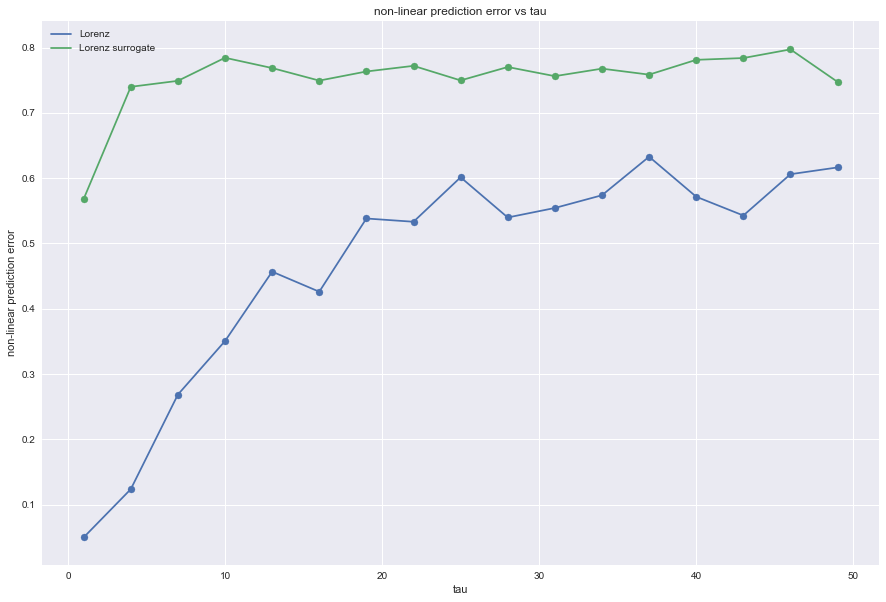

In [36]:
results_original = np.load("error_list.npy")
plt.figure(figsize=(15,10))
plt.plot(tau_range, list(results_original[n]))
plt.scatter(tau_range, list(results_original[n]))
plt.plot(tau_range, list(results))
plt.scatter(tau_range, list(results))
plt.title("non-linear prediction error vs tau")
plt.legend(["Lorenz", "Lorenz surrogate"])
plt.xlabel("tau")
plt.ylabel("non-linear prediction error")
plt.show()

In [ ]:
# Perform all the necessary imports to run the notebook
import numpy as np
from scipy.io import loadmat
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
sb.set()
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display

In [ ]:
# Load the channel data and channel names into a dataframe
data = loadmat("EEG2.mat")
channels = [e[0][0] for e in data["channelNameArray"]]
df = pd.DataFrame(data["EEG"], columns=channels)
df.head()

In [ ]:
def plot_eeg(timesteps=None, channels=None, sampling_rate=None, title=""):
    if not timesteps:
        timesteps = (0, len(df))
    if not channels:
        channels = (0, len(df.columns))
    df_chopped = df[df.columns[channels[0] : channels[1]]][timesteps[0] : timesteps[1]]
    df_offseted = df_chopped.copy()
    df_range = np.average(df_chopped.std())*4*2  # separate signals 4 stds apart
    voltage_offset = np.arange(0,len(df_chopped.columns)*df_range, df_range)
    for i,c in enumerate(df_chopped.columns):
        df_offseted[c] += voltage_offset[i]
    ax = df_offseted.plot(legend=False, figsize=(17,9))
    ax.set_yticks(voltage_offset)
    ax.set_yticklabels(df_chopped.columns)
    if sampling_rate:
        xticks = np.linspace(timesteps[0], timesteps[1], 10)
        xticklabels = ['%.2f' % (f,) for f in np.linspace(timesteps[0]/sampling_rate, timesteps[1]/sampling_rate, 10)]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_xlabel("t (s)")
    else:
        ax.set_xlabel("t (a.u.)")
    ax.set_title(title)
    ax.set_ylabel("channels")
    plt.show()
    

In [ ]:
plot_eeg()

In [ ]:
def interactive_plot_eeg(timesteps, channels):
    return plot_eeg(timesteps, channels, sampling_rate=1)

slider_timestep = widgets.IntRangeSlider(
    value=[0, len(df)],
    min=0,
    max=len(df),
    step=10,
    description='Timestep range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
slider_channel = widgets.IntRangeSlider(
    value=[0, len(df.columns)],
    min=0,
    max=len(df.columns),
    step=1,
    description='Channel range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
widgets.interact_manual(
    interactive_plot_eeg,
    timesteps=slider_timestep,
    channels=slider_channel,
    continuous_update=False
)
display()

In [ ]:
df["TBPL_5"][0:90000].plot()

In [ ]:
signal_range = [df["TBPL_5"][0:90000]] * tau_len
results = view.map(
    calculate_prediction_error,
    signal_range,
    m_range,
    tau_range,
    w_range,
    h_range,
    k_range
)
results.wait()